## Importing the relevant packages

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2 
import seaborn as sns
sns.set()

## Importing the Data and Pre-processing 

In [2]:
raw_csv_data = pd.read_csv("Index2018.csv") 
df_comp=raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
df_comp.set_index("date", inplace=True)
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')

In [3]:
df_comp['market_value']=df_comp.ftse

In [4]:
del df_comp['spx']
del df_comp['dax']
del df_comp['ftse']
del df_comp['nikkei']
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

In [5]:
import warnings
warnings.filterwarnings("ignore")

## The LLR Test

In [6]:
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))    
    p = chi2.sf(LR, DF).round(3)
    return p

## Creating Returns

In [7]:
df['returns'] = df.market_value.pct_change(1)*100

# The ARMA Model

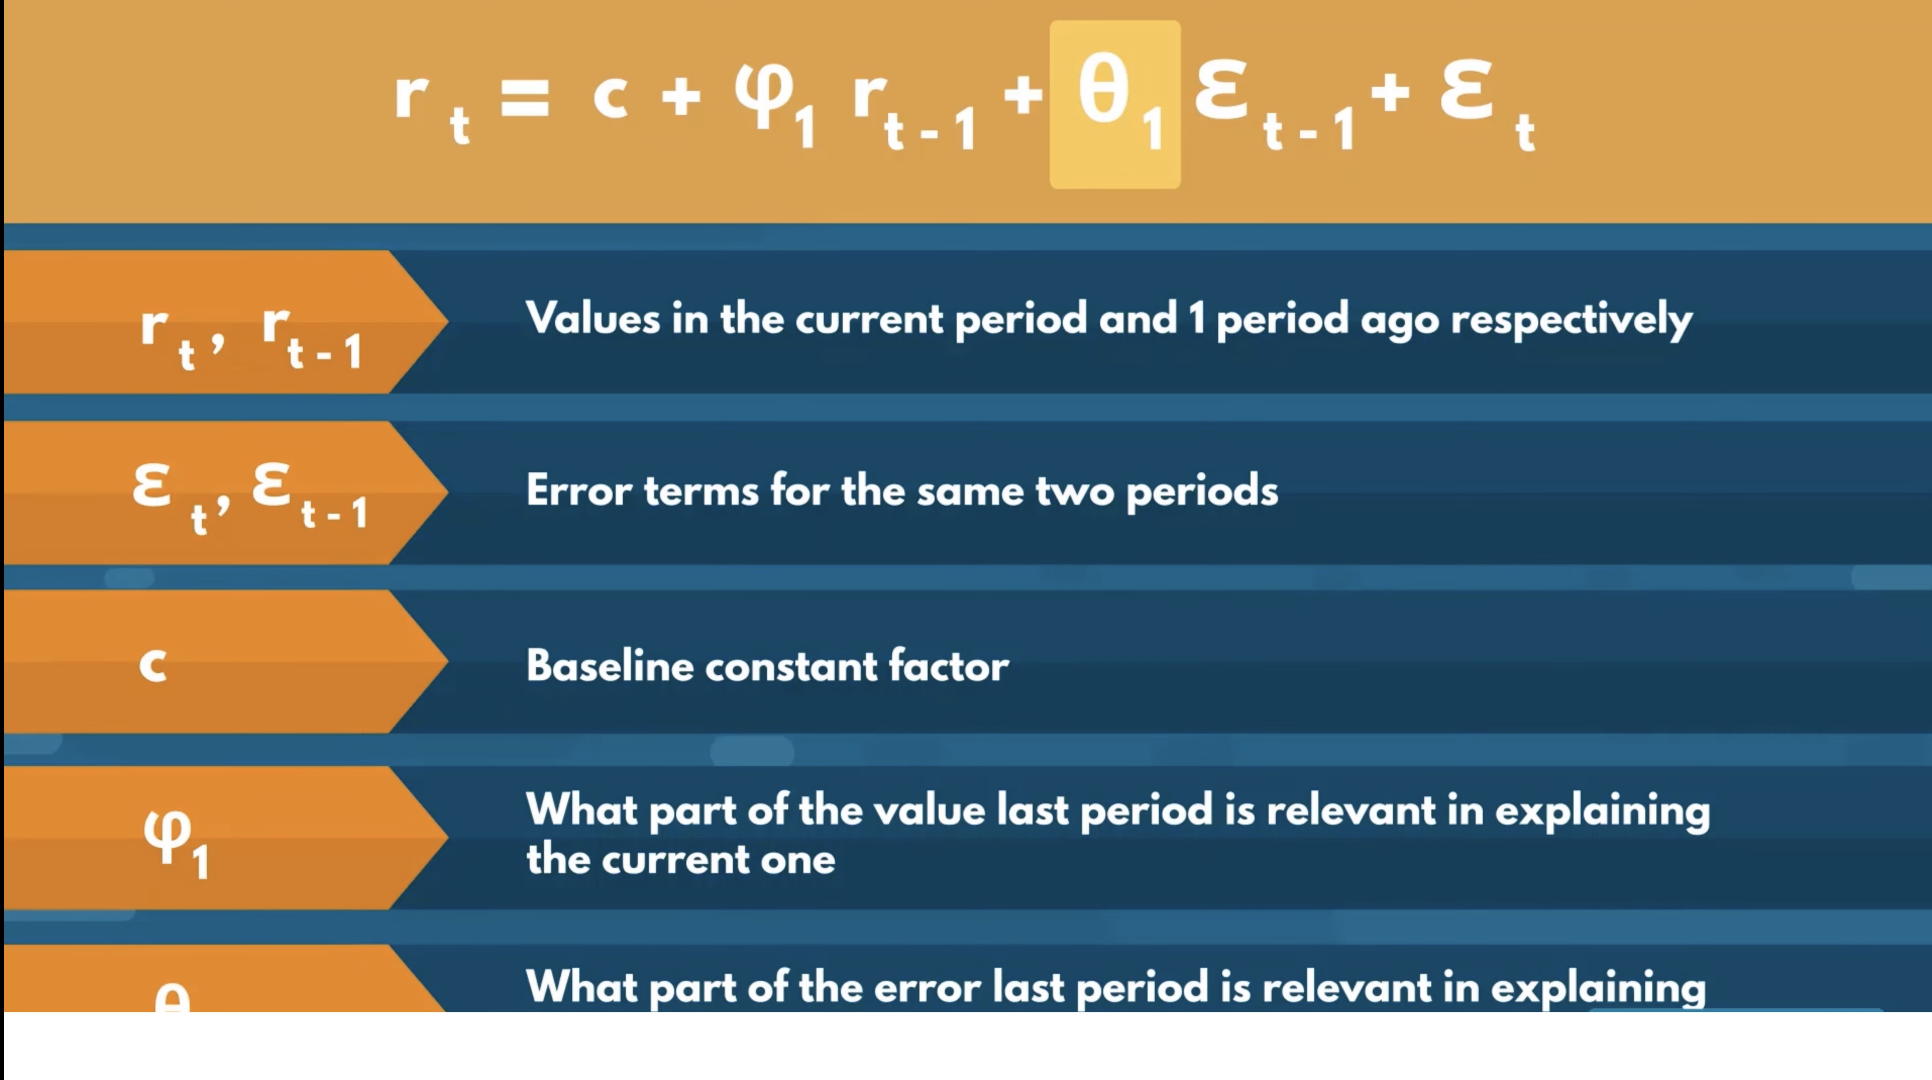

The ARMA model has 2 order parameters, (p,q), so takes the previous vvalues up to p periods ago and the residuals up to q lags. They can be the same or different depending on the situation, it depends on the significance of the predictors.

## ARMA(1,1)

In [10]:
model_ret_ar_1_ma_1 = ARIMA(df.returns[1:], order=(1,0,1))
results_ret_ar_1_ma_1 = model_ret_ar_1_ma_1.fit()
results_ret_ar_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -7916.500
Date:                Mon, 12 Feb 2024   AIC                          15841.000
Time:                        08:44:42   BIC                          15867.085
Sample:                    01-10-1994   HQIC                         15850.140
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.290      0.197      -0.010       0.048
ar.L1          0.7650      0.045     16.995      0.000       0.677       0.853
ma.L1         -0.8142      0.040    -20.187      0.000      -0.893      -0.735
sigma2         1.3718      0.014     98.110      0.000       1.344       1.399
===================================================================================
Ljung-Box (L1) (Q):                   2.06   Jarque-Bera (JB):              7488.92
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               2.03   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The Autoregression coefficient 0.7650, suggests that there's a positive tendency between past and present values. Returns move in trends of consecutive positive or negative values. Periods of persistent increase or decreases when translated to prices.

The negative MA coefficient is slightlt harder to interpret. It suggests that we should be moving away from the past period (t-1) values. An explanation in financial terms would be that these past errors ensure we don't get a "Fool in the shower" type of error, to elaborate we want to prevent our targets from moving before we've accounted for them.

In [13]:
model_ret_ar_1 = ARIMA(df.returns[1:], order = (1,0,0))
model_ret_ma_1 = ARIMA(df.returns[1:], order = (0,0,1))

In [14]:
print("\nARMA vs AR ", LLR_test(model_ret_ar_1, model_ret_ar_1_ma_1))
print("\nARMA vs MA ", LLR_test(model_ret_ma_1, model_ret_ar_1_ma_1))


ARMA vs AR  0.0

ARMA vs MA  0.0


The LLR test suggests a p-value of zero, so this suggests that using past errors in conjunction with past values result in much better estimators. Our past estimators (past values and past errors) perform better as predictors than actual past values. This is a bold statement, but if it is true it means that ARMA models ought to perform well when forecasting values into the future.

## Higher-Lag ARMA Models

There's a slight difference here ecause we have 2 order parameters to take into account. For arma model we usually take a different approach. Adding MA values (incresing q) would allow AR models to calibrate faster and adjust to some huge shock, while increasing the AR value p, allows the MA terms a much better foundation for predictions. So what we do is we start with an over-parameterized model ARMA(P,Q), and then we remove some parameters until we have all coefficient significant, a high log-likelihood and a low information criteria. Such model would describe the data best. Later on we we'll check whether there's an overfit.

Now to start our modelling we again use the ACF for the MA and the PACF for the AR model in order to figure out a starting point.

The AR and MA models complement one an other, so it makes sense that the optimal ARMA model would contain fewer components of each type. So we expect from the plots to have for the MA no more the q=8 and for the AR no more than p=6. 
If AR(6) and MA(8) were able to explain the changes (period to period) on their own, then using them simultaneously would be redundant.

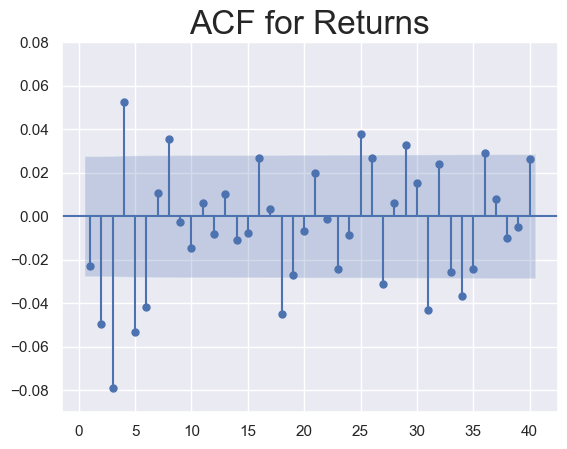

In [20]:
sgt.plot_acf(df.returns[1:], zero = False, lags = 40)
plt.title("ACF for Returns", size = 24)
plt.ylim(-0.09, 0.08)
plt.show()

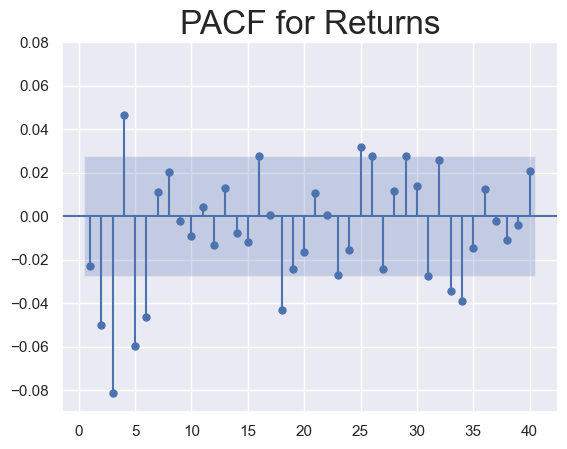

In [21]:
sgt.plot_pacf(df.returns[1:], zero = False, lags = 40)
plt.title("PACF for Returns", size = 24)
plt.ylim(-0.09, 0.08)
plt.show()

Before we said that we often start with ano over-parameterized model so in this case it would be the ARMA(8,6), the only downside of doing so is that many coefficient would probably cancel each other out (this is a really slow process).

In [24]:
model_ret_ar_3_ma_3 = ARIMA(df.returns[1:], order=(3,0,3))
results_ret_ar_3_ma_3 = model_ret_ar_3_ma_3.fit()

In [25]:
LLR_test(model_ret_ar_1_ma_1, model_ret_ar_3_ma_3, DF = 4)

0.0

In [26]:
results_ret_ar_3_ma_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(3, 0, 3)   Log Likelihood               -7893.515
Date:                Mon, 12 Feb 2024   AIC                          15803.030
Time:                        09:13:12   BIC                          15855.200
Sample:                    01-10-1994   HQIC                         15821.311
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.281      0.200      -0.010       0.048
ar.L1         -0.1880      0.068     -2.780      0.005      -0.321      -0.055
ar.L2         -0.2926      0.054     -5.380      0.000      -0.399      -0.186
ar.L3          0.4469      0.062      7.252      0.000       0.326       0.568
ma.L1          0.1690      0.063      2.686      0.007       0.046       0.292
ma.L2          0.2260      0.052      4.328      0.000       0.124       0.328
ma.L3         -0.5442      0.056     -9.632      0.000      -0.655      -0.433
sigma2         1.3591      0.015     92.543      0.000       1.330       1.388
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):              6862.43
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               2.00   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

So the ARMA(3,3) is a better fit than the ARMA(1,1), but what about the other ARMA models in between? We should check them out, but where do we start from? 



In [28]:
model_ret_ar_3_ma_2 = ARIMA(df.returns[1:], order=(3,0,2))
results_ret_ar_3_ma_2 = model_ret_ar_3_ma_2.fit()
results_ret_ar_3_ma_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(3, 0, 2)   Log Likelihood               -7895.747
Date:                Mon, 12 Feb 2024   AIC                          15805.495
Time:                        09:16:20   BIC                          15851.143
Sample:                    01-10-1994   HQIC                         15821.491
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.211      0.226      -0.012       0.049
ar.L1         -0.6778      0.055    -12.298      0.000      -0.786      -0.570
ar.L2         -0.5082      0.063     -8.035      0.000      -0.632      -0.384
ar.L3         -0.1141      0.009    -12.755      0.000      -0.132      -0.097
ma.L1          0.6561      0.056     11.747      0.000       0.547       0.766
ma.L2          0.4468      0.064      7.031      0.000       0.322       0.571
sigma2         1.3604      0.015     91.796      0.000       1.331       1.389
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6513.61
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.99   Skew:                            -0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

It is interesting to notice how the absolute value of the coefficient becomes less relevant the further back in time we go. The fac that the P-value for the constant tells us it's not significantly different from zero is not a problem cause in an efficient market, Returns should be close to 0 anyway.

In [29]:
model_ret_ar_2_ma_3 = ARIMA(df.returns[1:], order=(2,0,3))
results_ret_ar_2_ma_3 = model_ret_ar_2_ma_3.fit()
results_ret_ar_2_ma_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(2, 0, 3)   Log Likelihood               -7895.587
Date:                Mon, 12 Feb 2024   AIC                          15805.175
Time:                        09:22:08   BIC                          15850.823
Sample:                    01-10-1994   HQIC                         15821.170
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.015      1.224      0.221      -0.011       0.049
ar.L1         -0.5600      0.057     -9.777      0.000      -0.672      -0.448
ar.L2         -0.4178      0.065     -6.381      0.000      -0.546      -0.289
ma.L1          0.5373      0.057      9.417      0.000       0.425       0.649
ma.L2          0.3531      0.066      5.383      0.000       0.225       0.482
ma.L3         -0.1159      0.009    -12.679      0.000      -0.134      -0.098
sigma2         1.3604      0.015     91.315      0.000       1.331       1.390
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6515.27
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.99   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
LLR_test(model_ret_ar_2_ma_3, model_ret_ar_3_ma_3)

0.042

In [32]:
model_ret_ar_3_ma_1 = ARIMA(df.returns[1:], order=(3,0,1))
results_ret_ar_3_ma_1 = model_ret_ar_3_ma_1.fit()
results_ret_ar_3_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(3, 0, 1)   Log Likelihood               -7899.072
Date:                Mon, 12 Feb 2024   AIC                          15810.144
Time:                        09:25:28   BIC                          15849.271
Sample:                    01-10-1994   HQIC                         15823.855
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.247      0.212      -0.011       0.048
ar.L1         -0.5074      0.062     -8.155      0.000      -0.629      -0.385
ar.L2         -0.0638      0.009     -7.026      0.000      -0.082      -0.046
ar.L3         -0.1102      0.008    -13.611      0.000      -0.126      -0.094
ma.L1          0.4835      0.064      7.607      0.000       0.359       0.608
sigma2         1.3623      0.015     92.784      0.000       1.333       1.391
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              6490.48
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               2.00   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
LLR_test(model_ret_ar_3_ma_1, model_ret_ar_3_ma_2)

0.01

In [34]:
model_ret_ar_2_ma_2 = ARIMA(df.returns[1:], order=(2,0,2))
results_ret_ar_2_ma_2 = model_ret_ar_2_ma_2.fit()
results_ret_ar_2_ma_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -7914.692
Date:                Mon, 12 Feb 2024   AIC                          15841.384
Time:                        09:26:42   BIC                          15880.511
Sample:                    01-10-1994   HQIC                         15855.095
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.290      0.197      -0.010       0.048
ar.L1         -0.0969      0.091     -1.068      0.286      -0.275       0.081
ar.L2          0.6975      0.066     10.509      0.000       0.567       0.828
ma.L1          0.0399      0.092      0.435      0.663      -0.140       0.220
ma.L2         -0.7259      0.071    -10.274      0.000      -0.864      -0.587
sigma2         1.3708      0.014     95.248      0.000       1.343       1.399
===================================================================================
Ljung-Box (L1) (Q):                   4.33   Jarque-Bera (JB):              7237.20
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               2.02   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
model_ret_ar_1_ma_3 = ARIMA(df.returns[1:], order=(1,0,3))
results_ret_ar_1_ma_3 = model_ret_ar_1_ma_3.fit()
results_ret_ar_1_ma_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(1, 0, 3)   Log Likelihood               -7896.838
Date:                Mon, 12 Feb 2024   AIC                          15805.676
Time:                        09:23:16   BIC                          15844.803
Sample:                    01-10-1994   HQIC                         15819.386
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.265      0.206      -0.010       0.048
ar.L1         -0.4693      0.060     -7.878      0.000      -0.586      -0.353
ma.L1          0.4469      0.060      7.437      0.000       0.329       0.565
ma.L2         -0.0637      0.009     -7.277      0.000      -0.081      -0.047
ma.L3         -0.1182      0.008    -14.693      0.000      -0.134      -0.102
sigma2         1.3610      0.015     92.540      0.000       1.332       1.390
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6401.49
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               2.00   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
print("\n ARMA(3,2): \tLL = ", results_ret_ar_3_ma_2.llf, "\tAIC = ", results_ret_ar_3_ma_2.aic)
print("\n ARMA(1,3): \tLL = ", results_ret_ar_1_ma_3.llf, "\tAIC = ", results_ret_ar_1_ma_3.aic)


 ARMA(3,2): 	LL =  -7895.747490025438 	AIC =  15805.494980050877

 ARMA(1,3): 	LL =  -7896.837909205716 	AIC =  15805.675818411431


So we got to the conclusion that the ARMA(3,2) is the best model. We got here by starting from the over-parameterized model and tested all the way back to the ARMA(1,1). We found finally a model that outperforms all of its simpler models and at the same time has all significant coefficient.

## Residuals for Returns

In [36]:
df['res_ret_ar_3_ma_2'] = results_ret_ar_3_ma_2.resid[1:]

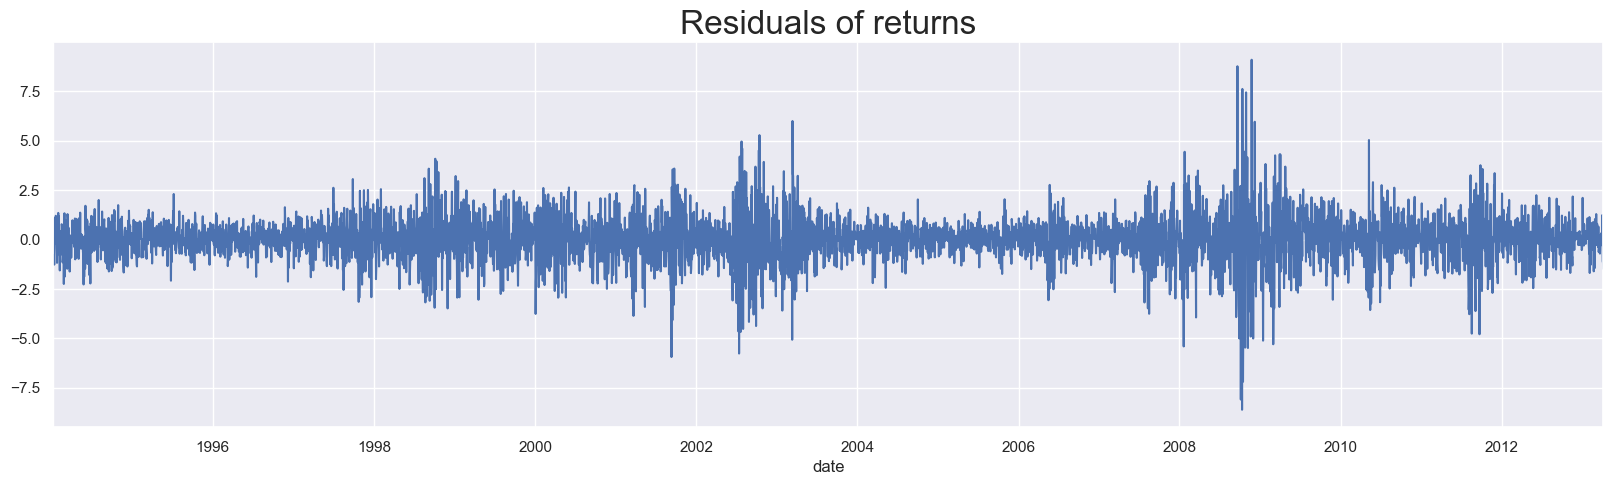

In [38]:
df.res_ret_ar_3_ma_2.plot(figsize = (20,5))
plt.title('Residuals of returns', size = 24)
plt.show()

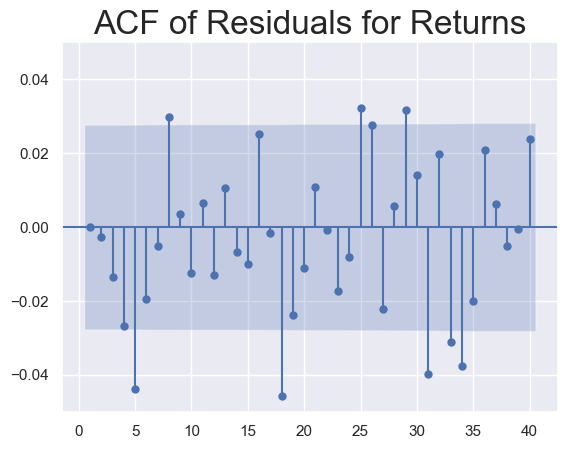

In [42]:
sgt.plot_acf(df.res_ret_ar_3_ma_2[2:], zero = False, lags = 40)
plt.title('ACF of Residuals for Returns', size = 24)
plt.ylim(-0.05,0.05)
plt.show()

Interestingly the acf for the residuals of the ARMA model are more significant than those of the AR and MA model. Obviously cause the latters accounted for the fifth lag. But judging from the ACF plot, accounting for either returns (AR, so p=5) or residuals (MA, so q=5) 5 periods ago, could improve our predictions!

So we should start from the ARMA(5,5), find all the models with all coefficients significant. Run the LLR test of the nested ones and compare the log-likelihood and AIC values for the others.

## Reevaluating Model Selection

In [43]:
model_ret_ar_5_ma_5 = ARIMA(df.returns[1:], order=(5,0,5))
results_ret_ar_5_ma_5 = model_ret_ar_5_ma_5.fit()
results_ret_ar_5_ma_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(5, 0, 5)   Log Likelihood               -7882.933
Date:                Mon, 12 Feb 2024   AIC                          15789.865
Time:                        09:51:19   BIC                          15868.119
Sample:                    01-10-1994   HQIC                         15817.286
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0195      0.015      1.315      0.189      -0.010       0.049
ar.L1         -0.0824      0.124     -0.665      0.506      -0.325       0.160
ar.L2         -0.5513      0.083     -6.643      0.000      -0.714      -0.389
ar.L3         -0.1200      0.077     -1.558      0.119      -0.271       0.031
ar.L4          0.2544      0.074      3.416      0.001       0.108       0.400
ar.L5          0.0913      0.093      0.979      0.328      -0.091       0.274
ma.L1          0.0562      0.124      0.455      0.649      -0.186       0.299
ma.L2          0.5031      0.083      6.058      0.000       0.340       0.666
ma.L3          0.0201      0.074      0.271      0.786      -0.125       0.165
ma.L4         -0.2394      0.072     -3.317      0.001      -0.381      -0.098
ma.L5         -0.1827      0.088     -2.065      0.039      -0.356      -0.009
sigma2         1.3539      0.015     90.058      0.000       1.324       1.383
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              6415.90
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               1.99   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

This model only has sever non significant coefficients, so we should now try all the different combinations, but the only 2 model that satisfy our needs are the ARMA(5,1) and the ARMA(1,5). The only problem is that these 2 models have the same degrees of freedom (6), so we can't use the LLR test. What we can do though is compare their Log-likelihood and AIC values.

In [45]:
model_ret_ar_5_ma_1 = ARIMA(df.returns[1:], order=(5,0,1))
results_ret_ar_5_ma_1 = model_ret_ar_5_ma_1.fit()
results_ret_ar_5_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(5, 0, 1)   Log Likelihood               -7889.311
Date:                Mon, 12 Feb 2024   AIC                          15794.623
Time:                        09:55:09   BIC                          15846.792
Sample:                    01-10-1994   HQIC                         15812.903
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.301      0.193      -0.010       0.047
ar.L1          0.3443      0.105      3.265      0.001       0.138       0.551
ar.L2         -0.0458      0.009     -4.859      0.000      -0.064      -0.027
ar.L3         -0.0652      0.010     -6.437      0.000      -0.085      -0.045
ar.L4          0.0741      0.012      6.089      0.000       0.050       0.098
ar.L5         -0.0813      0.009     -9.482      0.000      -0.098      -0.065
ma.L1         -0.3676      0.106     -3.455      0.001      -0.576      -0.159
sigma2         1.3570      0.015     92.272      0.000       1.328       1.386
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              6468.62
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               2.00   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [44]:
model_ret_ar_1_ma_5 = ARIMA(df.returns[1:], order=(1,0,5))
results_ret_ar_1_ma_5 = model_ret_ar_1_ma_5.fit()
results_ret_ar_1_ma_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(1, 0, 5)   Log Likelihood               -7890.974
Date:                Mon, 12 Feb 2024   AIC                          15797.949
Time:                        09:55:07   BIC                          15850.118
Sample:                    01-10-1994   HQIC                         15816.230
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.297      0.194      -0.010       0.047
ar.L1          0.3218      0.133      2.415      0.016       0.061       0.583
ma.L1         -0.3467      0.134     -2.593      0.010      -0.609      -0.085
ma.L2         -0.0406      0.010     -4.157      0.000      -0.060      -0.021
ma.L3         -0.0682      0.011     -6.099      0.000      -0.090      -0.046
ma.L4          0.0736      0.015      5.012      0.000       0.045       0.102
ma.L5         -0.0682      0.009     -7.411      0.000      -0.086      -0.050
sigma2         1.3579      0.015     91.599      0.000       1.329       1.387
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6465.72
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               2.00   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [48]:
print("ARMA(1,5): \tLL = ", results_ret_ar_1_ma_5.llf, "\tAIC = ", results_ret_ar_1_ma_5.aic)
print("ARMA(5,1): \tLL = ", results_ret_ar_5_ma_1.llf, "\tAIC = ", results_ret_ar_5_ma_1.aic)

ARMA(1,5): 	LL =  -7890.97443453786 	AIC =  15797.94886907572
ARMA(5,1): 	LL =  -7889.311291320006 	AIC =  15794.622582640011


Okay, so the ARMA(5,1) outperforms the ARMA(1,5). Now we should compare it to the ARMA(3,2) and see which one is best.
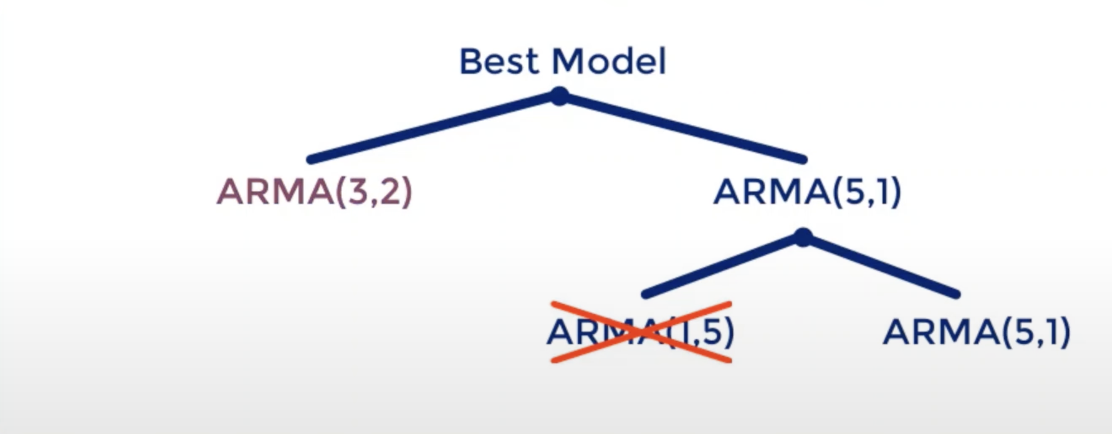

In [50]:
print("ARMA(5,1): \tLL = ", results_ret_ar_5_ma_1.llf, "\tAIC = ", results_ret_ar_5_ma_1.aic)
print("ARMA(3,2): \tLL = ", results_ret_ar_3_ma_2.llf, "\tAIC = ", results_ret_ar_3_ma_2.aic)

ARMA(5,1): 	LL =  -7889.311291320006 	AIC =  15794.622582640011
ARMA(3,2): 	LL =  -7895.747490025438 	AIC =  15805.494980050877


As we can see, the ARMA(5,1) has a higher LL and at the same time a lower AIC, so it looks like we have a winner. Which justifies our choice and makes it the best model yet. This is solid proof that the ARMA(3,2) was too simplistic for our task. 

**As we've seen the AR and MA models have respectively the PACF and ACF that provide the suggested optimal lag needed, unfortunately ARMA models lack such function, that is why we can make the mistake of starting off with a model, whose order is lower than the optimal one. This is why examining the residuals is crucial in finding the best approximator.** This is why we are gonna do next.

## Residuals for the New Model

In [52]:
df["res_ret_ar_5_ma_1"] = results_ret_ar_5_ma_1.resid

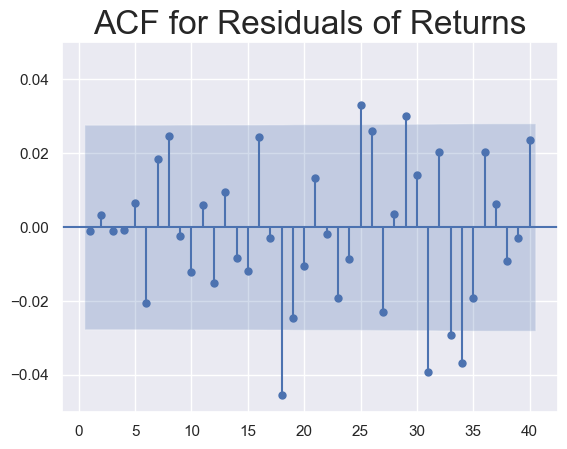

In [54]:
sgt.plot_acf(df.res_ret_ar_5_ma_1[1:], zero = False, lags = 40)
plt.title("ACF for Residuals of Returns", size = 24)
plt.ylim(-0.05,0.05)
plt.show()

As we can see now not only is the 5th lag not significant anymore but nor is the 8th nor any other lag before the 18th. If we wanted to make the model even better we could use even more lags, but this would predespose the model to failure when facing unfamiliar data.

Using even more lags will help us know with confidence how this specific data set modes rather than understant how the actual market returns fluctuate.

And also, as we said earlier, the effects of returns and errors tendo to diminish over time and so the further we go back in time, the less relevant the value are in predicting the future. Since the first 17 lags are not significant, we can say that the residuals are pretty much random which is what we were trying to achieve.

Next we'll see how ARMA model peform with non stationary data like prices.

## ARMA Models for Prices

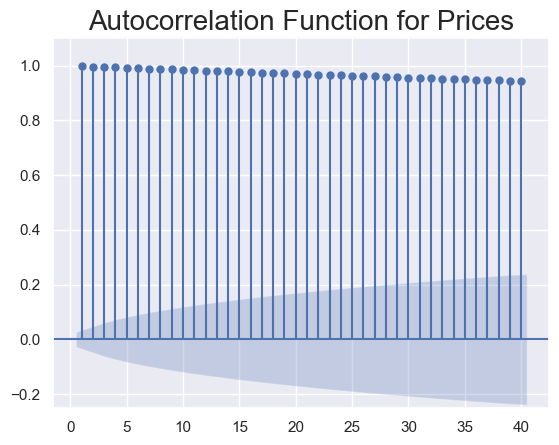

In [66]:
sgt.plot_acf(df.market_value, unbiased=True, zero = False, lags = 40)
plt.title("Autocorrelation Function for Prices",size=20)
plt.ylim(-0.25,1.1)
plt.show()

In this case the ACF suggests an infinite lag MA model, but we know that this kind of model is equal to the AR(1)

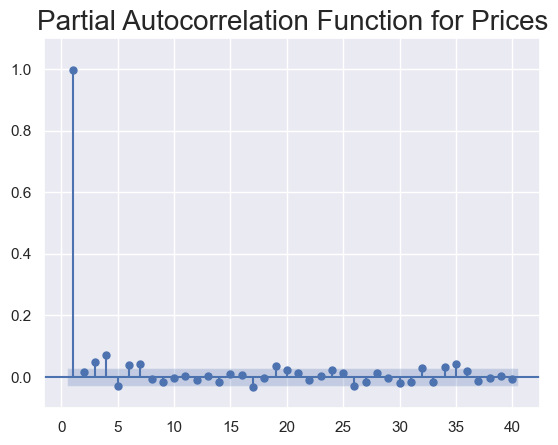

In [64]:
sgt.plot_pacf(df.market_value, lags = 40, alpha = 0.05, zero = False , method = ('ols'))
plt.title("Partial Autocorrelation Function for Prices",size=20)
plt.ylim(-0.1,1.1)
plt.show()

The PACF suggests a significance for the first 7 lags, so in this case as long as we include some AR components in our model, we should be able to describe the data well. 

In [67]:
model_ar_1_ma_1 = ARIMA(df.market_value, order=(1,0,1))
results_ar_1_ma_1 = model_ar_1_ma_1.fit()
results_ar_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -27621.875
Date:                Tue, 13 Feb 2024   AIC                          55251.749
Time:                        09:30:24   BIC                          55277.835
Sample:                    01-07-1994   HQIC                         55260.890
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6409    366.501     13.887      0.000    4371.312    5807.970
ar.L1          0.9982      0.001   1189.159      0.000       0.997       1.000
ma.L1         -0.0186      0.010     -1.894      0.058      -0.038       0.001
sigma2      3510.8350     41.068     85.489      0.000    3430.344    3591.326
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3280.53
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [68]:
df['res_ar_1_ma_1'] = results_ar_1_ma_1.resid

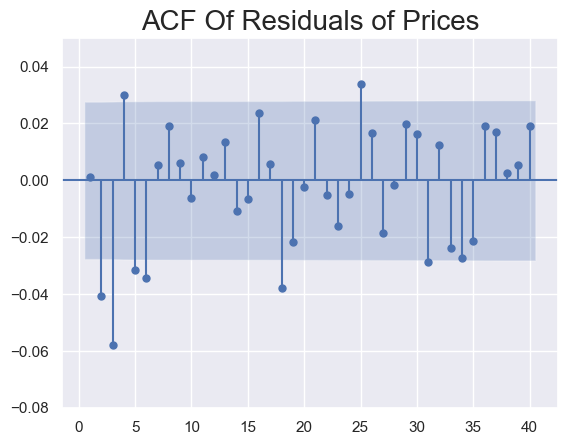

In [72]:
sgt.plot_acf(df.res_ar_1_ma_1, zero = False, lags = 40)
plt.title("ACF Of Residuals of Prices",size=20)
plt.ylim(-0.08,0.05)
plt.show()

In [76]:
model_ar_6_ma_6 = ARIMA(df.market_value, order=(6,0,6))
results_ar_6_ma_6 = model_ar_6_ma_6.fit()
results_ar_6_ma_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(6, 0, 6)   Log Likelihood              -27591.277
Date:                Tue, 13 Feb 2024   AIC                          55210.553
Time:                        09:36:32   BIC                          55301.853
Sample:                    01-07-1994   HQIC                         55242.546
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6408    511.817      9.944      0.000    4086.499    6092.783
ar.L1          0.7381      0.925      0.798      0.425      -1.075       2.551
ar.L2          0.2446      1.552      0.158      0.875      -2.798       3.287
ar.L3         -0.4060      1.220     -0.333      0.739      -2.798       1.986
ar.L4          0.3422      0.757      0.452      0.651      -1.142       1.826
ar.L5         -0.1099      0.418     -0.263      0.792      -0.928       0.708
ar.L6          0.1891      0.253      0.746      0.455      -0.307       0.685
ma.L1          0.2407      0.925      0.260      0.795      -1.571       2.053
ma.L2         -0.0389      0.666     -0.058      0.953      -1.345       1.267
ma.L3          0.3344      0.561      0.596      0.551      -0.766       1.435
ma.L4          0.0823      0.243      0.339      0.734      -0.393       0.558
ma.L5          0.1449      0.300      0.483      0.629      -0.443       0.733
ma.L6         -0.0865      0.085     -1.018      0.309      -0.253       0.080
sigma2      3468.7522     43.249     80.204      0.000    3383.985    3553.519
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2960.91
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                            -0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [78]:
model_ar_5_ma_6 = ARIMA(df.market_value, order=(5,0,6))
results_ar_5_ma_6 = model_ar_5_ma_6.fit()
results_ar_5_ma_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(5, 0, 6)   Log Likelihood              -27589.840
Date:                Tue, 13 Feb 2024   AIC                          55205.681
Time:                        09:40:54   BIC                          55290.459
Sample:                    01-07-1994   HQIC                         55235.388
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6407   1555.305      3.272      0.001    2041.300    8137.982
ar.L1          0.6231      0.654      0.953      0.341      -0.658       1.905
ar.L2         -0.2436      0.747     -0.326      0.744      -1.707       1.220
ar.L3          0.1666      0.643      0.259      0.796      -1.093       1.427
ar.L4          0.5662      0.528      1.071      0.284      -0.470       1.602
ar.L5         -0.1133      0.106     -1.068      0.286      -0.321       0.095
ma.L1          0.3554      0.653      0.544      0.586      -0.924       1.635
ma.L2          0.5632      0.158      3.569      0.000       0.254       0.873
ma.L3          0.3452      0.519      0.665      0.506      -0.672       1.362
ma.L4         -0.1556      0.103     -1.506      0.132      -0.358       0.047
ma.L5         -0.0843      0.013     -6.312      0.000      -0.111      -0.058
ma.L6         -0.0505      0.062     -0.809      0.419      -0.173       0.072
sigma2      3466.4591     42.285     81.978      0.000    3383.581    3549.337
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3041.30
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [79]:
model_ar_6_ma_1 = ARIMA(df.market_value, order=(6,0,1))
results_ar_6_ma_1 = model_ar_6_ma_1.fit()
results_ar_6_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(6, 0, 1)   Log Likelihood              -27594.195
Date:                Tue, 13 Feb 2024   AIC                          55206.389
Time:                        09:41:44   BIC                          55265.082
Sample:                    01-07-1994   HQIC                         55226.956
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6310    525.548      9.684      0.000    4059.576    6119.686
ar.L1          1.3904      0.158      8.820      0.000       1.081       1.699
ar.L2         -0.4352      0.154     -2.829      0.005      -0.737      -0.134
ar.L3         -0.0102      0.017     -0.612      0.540      -0.043       0.022
ar.L4          0.1126      0.016      6.904      0.000       0.081       0.145
ar.L5         -0.1156      0.020     -5.708      0.000      -0.155      -0.076
ar.L6          0.0573      0.009      6.198      0.000       0.039       0.075
ma.L1         -0.4109      0.158     -2.599      0.009      -0.721      -0.101
sigma2      3471.7086     42.119     82.427      0.000    3389.157    3554.260
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              3031.89
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [80]:
print("ARMA(5,6):  \t LL = ", results_ar_5_ma_6.llf, "\t AIC = ", results_ar_5_ma_6.aic)
print("ARMA(6,1):  \t LL = ", results_ar_6_ma_1.llf, "\t AIC = ", results_ar_6_ma_1.aic)

ARMA(5,6):  	 LL =  -27589.840413506332 	 AIC =  55205.680827012664
ARMA(6,1):  	 LL =  -27594.194635946267 	 AIC =  55206.389271892534


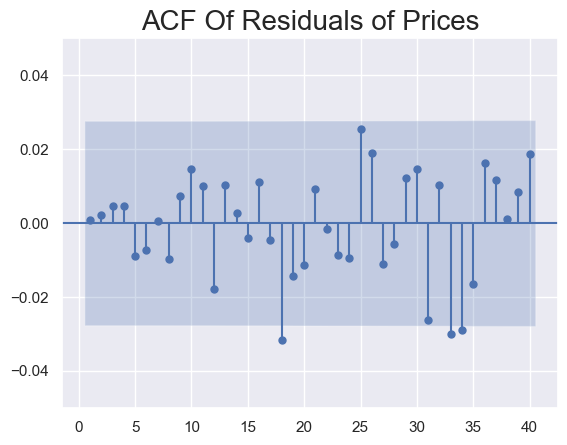

In [83]:
df['res_ar_5_ma_6'] = results_ar_5_ma_6.resid
sgt.plot_acf(df.res_ar_5_ma_6, zero = False, lags = 40)
plt.title("ACF Of Residuals of Prices",size=20)
plt.ylim(-0.05,0.05)
plt.show()

The residuals resemble white noise.

But didn't we say that arma models perform poorly when modelling non stationary data? Let's have a look at the LL value of the 2 models, ARMA(5,6) for prices and ARMA(5,1) for returns.

## ARMA for Returns vs ARMA for Prices

In [84]:
print("ARMA(5,6):  \t LL = ", results_ar_5_ma_6.llf, "\t AIC = ", results_ar_5_ma_6.aic)
print("ARMA(5,1):  \t LL = ", results_ret_ar_5_ma_1.llf, "\t AIC = ", results_ret_ar_5_ma_1.aic)

ARMA(5,6):  	 LL =  -27589.840413506332 	 AIC =  55205.680827012664
ARMA(5,1):  	 LL =  -7889.311291320006 	 AIC =  15794.622582640011


This means that even though we can model prices using ARMA models, they perform much worse compared to their ability to estimate stationary data. That's because something is missing. We'll discuss how to adapt ARMA models to handle non stationary data.

# ARMA models for non-stationary data

As we've seen ARMA models are good for stationary data, but are not so good when it comes to non-stationary data. The solution is using the ARIMA, **Autoregressive Integrated Moving Average Model**. Integrated accounts for the number of non-seasonal differences we need to examine to establish stationarity. In other words such a model targets the difference between the values in period t and the one preceding it, it essentially estimates the jumps between prices rather than the actual prices. In a sense it assumes a sort of random walk element to our dataset and models the differences from one period to the next instead of the values themselves. The purpose behind this complication of the model is to ensure stationarity no matter the underlying data. For most data, a single factor of integration is enough to reach stationarity. When you think about it, transforming prices into price returns is a way of brute integration, we simply took a manually integrated version of our dataset and we scaled every element with respect to the previous one. Of course since we did not multiply the entire integrated time series by a constant, returns are slightly different than simply integrated prices. However similarities between the two time series are apparent so we should consider which models describe returns best when dealing with integrated prices. Now that we know the existence of this tool, we are finally ready to model and estimate non stationary series like market indices and a lot. Our next section will deal with the algebra behind said models and the tecniques to find the model that best describe the FTSE prices.